# Natural Language Processing with Disaster Tweets

In this project, data from Tweets are provided and classified either as a Tweet about a real disaster or a Tweet that resembles Tweets about real disasters (i.e. not an actual disaster). A machine learning model is built to predict which Tweets are about real disasters and which ones aren't. Dataset and challenge from Kaggle.com.

The column descriptions are as follows: 

- id: A unique identifier for each Tweet
- target: '1' if the Tweet is describing a real disaster, and '0' if the Tweet is not actually about a disaster.
- location: The location the Tweet was sent from
- keyword: A particular keyword from this Tweet

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import re

In [3]:
df = pd.read_csv('./train.csv')

## Exploratory Data Analysis

In [4]:
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<Axes: xlabel='target', ylabel='count'>

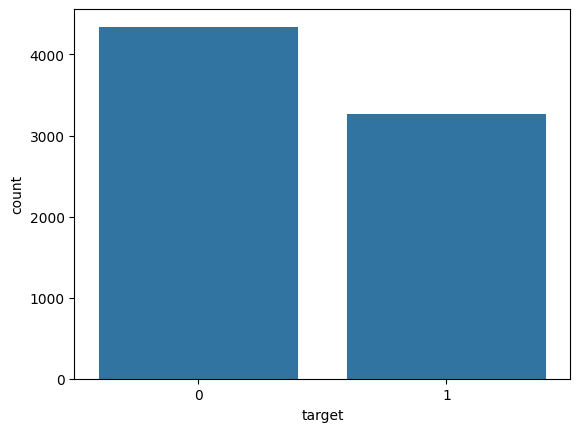

In [6]:
sns.countplot(df, x='target')

## Cleaning

Some of the values in the text column also contain links. Those links should be removed as they are not useful for information extraction.

In [238]:
df = pd.read_csv('./train.csv')

In [239]:
df['text'] = df['text'].apply(lambda x: re.sub(r'https://\S+', '', x))
df['text'] = df['text'].apply(lambda x: re.sub(r'http://\S+', '', x))
df['text'] = df['text'].str.lower()

The text column is converted into all lowercase as well.

In [240]:
y = df['target']
X = df['text']

In [241]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## Model Selection


A helper function is created to fit, predict, and print the classification report of each model below.

In [248]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, NuSVC
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from sklearn.metrics import f1_score, classification_report

In [289]:
def train_model(model, vectorizer):
    X_train_v = vectorizer.fit_transform(X_train)
    X_test_v = vectorizer.transform(X_test)
    model.fit(X_train_v, y_train)
    y_pred = model.predict(X_test_v)
    score = f1_score(y_test, y_pred)
    return[model, vectorizer, score]

In [259]:
models = [MultinomialNB(), KNeighborsClassifier(), RandomForestClassifier(), LinearSVC(), NuSVC(), LogisticRegression()]
stop = ['english', None]
vect = [CountVectorizer, TfidfVectorizer]

In [ ]:
metrics_df = pd.DataFrame()

for vectorizer in vect:
    for stop_word in stop:
        for model in models:
            new = train_model(model, vectorizer(stop_words=stop_word))
            metrics_df = metrics_df.append(pd.Series(new), ignore_index=True)

In [333]:
metrics_df.columns = ['Model', 'Vect', 'f1']
metrics_df.sort_values(by='f1', ascending=False).head()

,Model,Vect,f1
6,MultinomialNB(),CountVectorizer(),0.744538
23,LogisticRegression(),TfidfVectorizer(),0.743103
10,NuSVC(),CountVectorizer(),0.740157
22,NuSVC(),TfidfVectorizer(),0.734764
0,MultinomialNB(),CountVectorizer(stop_words='english'),0.731148


MultinomialNB with a Count Vectorizer had the highest f1 score.

### Model Training

The model and vectorizer is then re-fitted/trained with the model with the highest f1 score, this time to the entire X data given in train.csv. 

In [340]:
cv = CountVectorizer()
X_cv = cv.fit_transform(X)

In [342]:
model = MultinomialNB()
model.fit(X_cv, y)

MultinomialNB()

### Submission

In [343]:
test_df = pd.read_csv('./test.csv')

In [345]:
test_df['text'] = test_df['text'].apply(lambda x: re.sub(r'https://\S+', '', x))
test_df['text'] = test_df['text'].apply(lambda x: re.sub(r'http://\S+', '', x))
test_df['text'] = test_df['text'].str.lower()

In [348]:
test_cv = cv.transform(test_df['text'])

In [350]:
predictions = model.predict(test_cv)

In [365]:
submission = pd.DataFrame([test_df['id']]).transpose()

In [367]:
submission['target'] = predictions

In [379]:
submission = submission.set_index('id')

In [380]:
submission.to_csv('./submission.csv')

The final score given after submission is 0.79681, meaning that the accuracy of the model is 79.681%.